## Create a boolean array from a shapely Polygon
For example to create a mask for a model grid based on the lat and lon.

See [here](https://www.lmehub.net/) for info on Large Marine Ecosystems. Shape file downloaded from [USGS](https://www.sciencebase.gov/catalog/item/55c77722e4b08400b1fd8244).

In [123]:
import xarray as xr
import geopandas as gpd
import numpy as np
from shapely import Point

In [124]:
# Get the shapefile for the Large Marine Ecosystems
rootdir = '/projects/SOCCOM/datasets/LargeMarineEcos/LME66/'
filename = 'LMEs66.shp'
df = gpd.read_file(rootdir+filename)
# Get an ESM4 grid file
rootdir = '/projects/SOCCOM/datasets/ESM4_PPE/archive/Richard.Slater/xanadu_esm4_20190304_mom6_ESM4_v1.0.3_rc1/GRID/'
filename = 'ocean.static.nc'
grid = xr.open_dataset(rootdir+filename)

In [125]:
# Reorganize geolon coordinate
grid['geolon'] = grid['geolon'].where(grid['geolon']>-180,grid['geolon']+360)

In [126]:
# Cut down grid size to make more manageable
# Grab Baltic Sea
gridnow = xr.Dataset(coords=grid['geolon'].coords)
gridnow['geolon'] = grid['geolon']
gridnow['geolat'] = grid['geolat']
cond = (grid['geolat']>0) & (grid['geolat']<30) & (grid['geolon']>-120) & (grid['geolon']<-80)
gridnow = gridnow.where(cond,drop=True)

In [127]:
gridnow

<xarray.Dataset>
Dimensions:  (yh: 84, xh: 80)
Coordinates:
  * xh       (xh) float64 -119.8 -119.2 -118.8 -118.2 ... -81.25 -80.75 -80.25
  * yh       (yh) float64 0.2564 0.5128 0.7692 1.026 ... 28.5 28.94 29.37 29.81
Data variables:
    geolon   (yh, xh) float32 -119.8 -119.2 -118.8 ... -81.25 -80.75 -80.25
    geolat   (yh, xh) float32 0.2564 0.2564 0.2564 0.2564 ... 29.81 29.81 29.81

### Single polygon

In [128]:
def polygon_to_mask(poly, gridx, gridy):
    '''Return boolean array for points in [gridx] and [gridy] that are contained within
    the Polygon. poly is a shapely polygon, [gridx] and [gridy] are MxN arrays.'''
    xy_arr = np.vstack((gridx.ravel(), gridy.ravel())).T
    inside = np.array([poly.contains(Point(xy)) for xy in xy_arr]).reshape(gridx.shape)
    return inside

In [129]:
# Select polygon
poly = df[df['LME_NAME']=='Gulf of California']['geometry'].iloc[0]

In [130]:
# Create mask
mask_arr = polygon_to_mask(poly,gridnow['geolon'].values,gridnow['geolat'].values)
mask = gridnow['geolon'].copy(data=mask_arr)

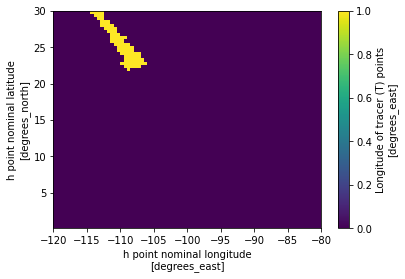

In [131]:
mask.plot()

### Multiple polygons
The rate limiting step here is to cycle through each xy-point. So, put that as the outer loop in the following...

In [132]:
ds = xr.Dataset(coords=gridnow['geolon'].coords)
gridx,gridy = gridnow['geolon'].values,gridnow['geolat'].values
xy_arr = np.vstack((gridx.ravel(), gridy.ravel())).T
# Set up numpy dictionary
inside_dict = {}
for index,row in df.iterrows():
    name = row['LME_NAME']
    inside_dict[name]=np.zeros(shape = len(xy_arr))
# Populate np arrays with boolean based on whether point in polygon
for i,xy in enumerate(xy_arr):
    if i%100==0:
        print(str(i)+' of '+str(len(xy_arr)))
    for name,inside in inside_dict.items():
        poly = df[df['LME_NAME']==name]['geometry'].iloc[0]
        inside[i]=poly.contains(Point(xy))
# Reshape boolean and store in Dataset
for name,inside in inside_dict.items():
    da=xr.DataArray(inside.reshape(gridx.shape).T,dims=ds.dims,coords=ds.coords)
    ds[name]=da

0 of 6720
100 of 6720
200 of 6720
300 of 6720
400 of 6720
500 of 6720
600 of 6720
700 of 6720
800 of 6720
900 of 6720
1000 of 6720
1100 of 6720
1200 of 6720
1300 of 6720
1400 of 6720
1500 of 6720
1600 of 6720
1700 of 6720
1800 of 6720
1900 of 6720
2000 of 6720
2100 of 6720
2200 of 6720
2300 of 6720
2400 of 6720
2500 of 6720
2600 of 6720
2700 of 6720
2800 of 6720
2900 of 6720
3000 of 6720
3100 of 6720
3200 of 6720
3300 of 6720
3400 of 6720
3500 of 6720
3600 of 6720
3700 of 6720
3800 of 6720
3900 of 6720
4000 of 6720
4100 of 6720
4200 of 6720
4300 of 6720
4400 of 6720
4500 of 6720
4600 of 6720
4700 of 6720
4800 of 6720
4900 of 6720
5000 of 6720
5100 of 6720
5200 of 6720
5300 of 6720
5400 of 6720
5500 of 6720
5600 of 6720
5700 of 6720
5800 of 6720
5900 of 6720
6000 of 6720
6100 of 6720
6200 of 6720
6300 of 6720
6400 of 6720
6500 of 6720
6600 of 6720
6700 of 6720


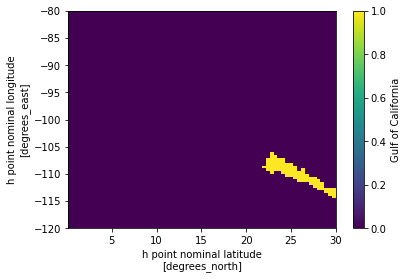

In [136]:
ds['Gulf of California'].plot()